In [1]:
import os
import sys
import numpy as np
import matplotlib
matplotlib.use('nbagg')
#from matplotlib import style
#style.use('ggplot')
import matplotlib.pyplot as plt

%load_ext autoreload
%autoreload 2

from astropy.io import fits
from mmtwfs.wfs import *
from mmtwfs.zernike import *

In [76]:
f9wfs = WFSFactory(wfs="f9", nzern=20, back_h=0.999, pup_offset=[0.45, 0.85], pup_size=440)

In [260]:
rad = 220
rvec = (np.arange(2. * rad) - rad) / rad
ry = rvec.reshape(-1, 1)
rx = rvec.reshape(1, -1)
nmodes = 37
modestart = 2

In [261]:
grid_rad = make_radial_matrix(2.*rad)
grid_ang = np.arctan2(ry, rx)
grid_mask = grid_rad <= 1.

In [262]:
zern_modes = [zernike_noll(zmode, grid_rad, grid_ang)*grid_mask for zmode in range(modestart, nmodes+modestart)]
zern_slopes = [zernike_slope_noll(zmode, grid_rad, grid_ang)*grid_mask for zmode in range(modestart, nmodes+modestart)]

In [263]:
zern_modes_mat = np.r_[zern_modes].reshape(nmodes, -1)
zern_slopes_mat = np.r_[zern_slopes]

In [264]:
zernike_slope_noll(2, grid_rad, grid_ang)

(array([[ 1.,  1.,  1., ...,  1.,  1.,  1.],
        [ 1.,  1.,  1., ...,  1.,  1.,  1.],
        [ 1.,  1.,  1., ...,  1.,  1.,  1.],
        ..., 
        [ 1.,  1.,  1., ...,  1.,  1.,  1.],
        [ 1.,  1.,  1., ...,  1.,  1.,  1.],
        [ 1.,  1.,  1., ...,  1.,  1.,  1.]]),
 array([[ -4.99600361e-16,   4.99600361e-16,   8.32667268e-16, ...,
          -8.88178420e-16,  -4.99600361e-16,   4.99600361e-16],
        [  4.99600361e-16,   0.00000000e+00,   0.00000000e+00, ...,
           0.00000000e+00,   5.55111512e-17,  -4.44089210e-16],
        [  8.88178420e-16,   0.00000000e+00,   0.00000000e+00, ...,
           0.00000000e+00,   0.00000000e+00,  -9.43689571e-16],
        ..., 
        [ -8.88178420e-16,   0.00000000e+00,   0.00000000e+00, ...,
           0.00000000e+00,  -5.55111512e-17,   8.88178420e-16],
        [ -4.99600361e-16,  -5.55111512e-17,   0.00000000e+00, ...,
           5.55111512e-17,   0.00000000e+00,   4.99600361e-16],
        [  4.99600361e-16,  -4.44089210e

In [265]:
r = f9wfs.modes['blue']['reference']
x = r['pup_coords'][0]
y = r['pup_coords'][1]

<IPython.core.display.Javascript object>


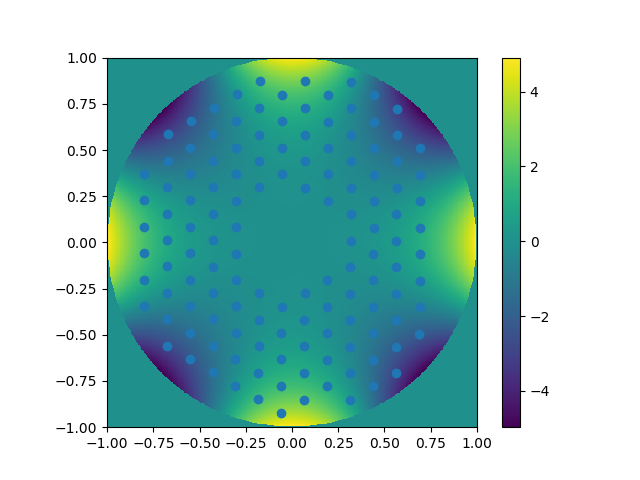

In [266]:
s = zern_slopes[19][1]
plt.imshow(s, origin='lower', extent=[-1, 1, -1, 1])
plt.colorbar()
plt.scatter(x, y)
plt.show()

In [267]:
np.nanmean(zern_slopes[1][1])

0.78167355371900826

<IPython.core.display.Javascript object>


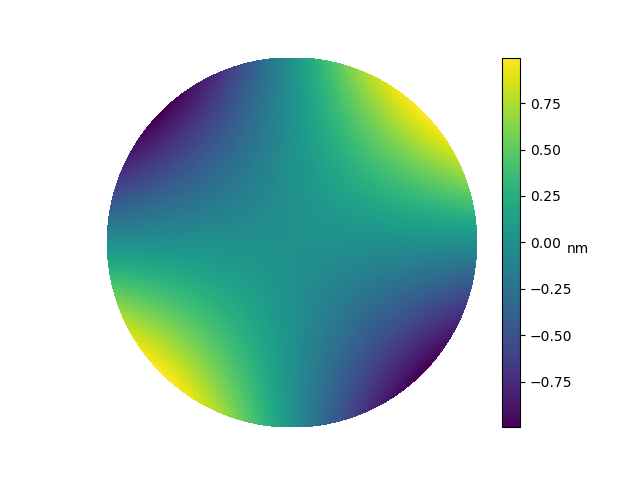

In [268]:
zv = ZernikeVector(Z05=1)

zv.plot_map()
plt.show()

<IPython.core.display.Javascript object>


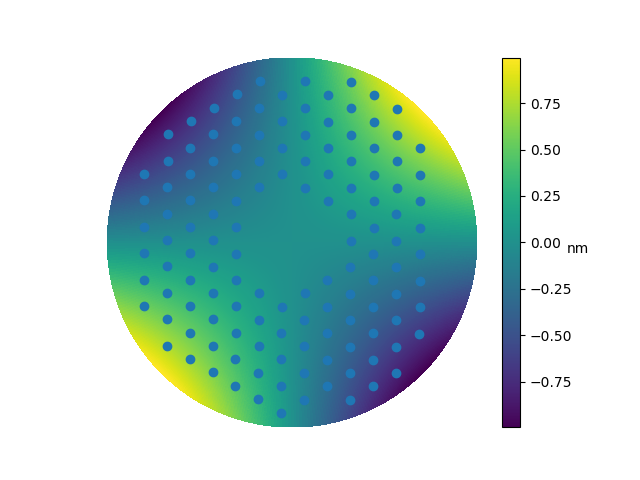

In [269]:
zv = ZernikeVector(Z05=1)
zv.plot_map()
plt.scatter(x, y)
plt.show()

In [270]:
rho, phi = cart2pol([x, y])

In [271]:
phi

array([-1.6341163 , -1.21794002, -1.78267682, -1.49369142, -1.05901522,
       -1.94647282, -1.64579679, -1.33206613, -1.47728126, -1.15335696,
       -0.89926843, -2.11913795, -1.82301974, -2.02115347, -1.6612081 ,
       -1.27965811, -0.96715968, -2.2907714 , -2.22461773, -1.88277548,
       -1.45249325, -1.06227025, -0.78687472, -2.45089669, -0.84340235,
       -0.62062541, -2.41838954, -2.12820488, -1.68634346, -1.20040802,
       -1.4117189 , -0.92810757, -0.64185057, -2.59044577, -2.37143581,
       -1.97923795, -1.73175939, -1.07019774, -0.67121347, -0.46959794,
       -2.73579892, -2.58291224, -2.29250643, -0.45857437, -2.57240278,
       -2.15152139, -1.33058716, -0.72031626, -2.75785457, -0.43738664,
       -0.29109588, -2.89570254, -2.79048509, -2.55447788, -0.81906625,
       -0.40103809, -0.23404392, -2.95121204, -2.84405427, -2.94536493,
       -0.14071945, -0.0917463 , -3.06924181, -3.03527685,  3.11271592,
        0.02966527,  0.0158102 ,  3.12262919,  0.18037863,  0.11

In [272]:
zern_slopes = [zernike_slope_noll(zmode, rho, phi) for zmode in range(modestart, nmodes+modestart)]

In [273]:
zslopes = np.array(zern_slopes)

In [274]:
zslopes2 = np.array(zern_slopes)

In [275]:
zern_modes_mat = np.r_[zern_slopes].reshape(nmodes, -1)  # X slope then Y slope for each mode
subapsize = f9wfs.modes['blue']['reference']['xspacing']
pixsize = f9wfs.pix_size.value
sfac = 1.

In [276]:
U, s, Vh = np.linalg.svd(zern_modes_mat * sfac, full_matrices=False)
s_sq = s**2
fk = s_sq/s_sq.sum()
entropy = -(1./np.log(len(s))) * np.sum(fk * np.log(fk))
#np.savez("svd.npz", s)
#nvec = np.argwhere(cums >= singval)[0][0]
nvec = np.argwhere(fk.cumsum() >= entropy)[0][0]

#s[nvec+1:] = np.inf
basis_inv_mat = np.dot(Vh.T, np.dot(np.diag(1.0/s), U.T))

In [277]:
s

array([ 51.93095915,  45.73333652,  38.01336796,  35.10663653,
        33.80106209,  32.77266131,  32.43193122,  30.90912997,
        29.72626863,  28.09475765,  26.62654596,  26.49104531,
        26.02714214,  25.26164998,  25.04573623,  24.4834134 ,
        23.70263579,  22.48110158,  21.32492116,  21.06249934,
        20.33744586,  19.93567713,  19.30450367,  18.71765144,
        18.12183441,  17.98916096,  17.24303408,  16.77761803,
        15.72632793,  15.29729033,  14.30910184,  12.81375675,
        10.53465474,  10.14443777,   9.62542446,   8.32756819,   2.81172119])

In [239]:
f9wfs = WFSFactory(wfs="f9", nzern=20, back_h=0.99, pup_offset=[0.45, 0.85], pup_size=440)
f9wfs.modes['blue']['reference']['xcen'] = 240
f9wfs.modes['blue']['reference']['ycen'] = 259.5
f9wfs.modes['blue']['reference']['pup_outer'] = 225.0


25.2252252252 14.5495495495


<IPython.core.display.Javascript object>


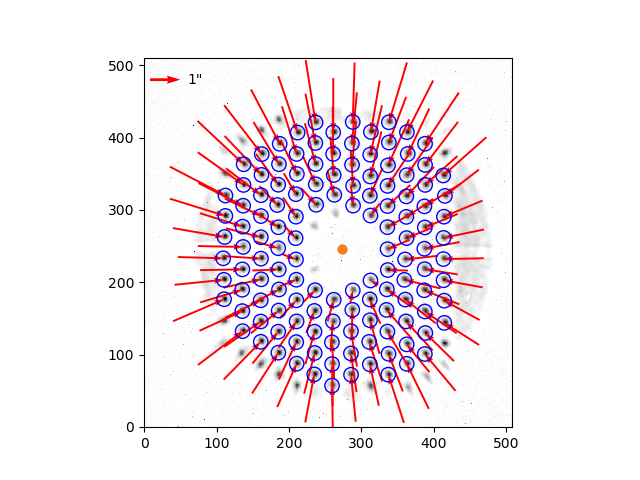

In [240]:
f9_file = "/Users/tim/MMT/wfsdat/20170318/final_tweak_0001.fits"
results = f9wfs.measure_slopes(f9_file, 'blue', plot=True)
plt.show()

In [255]:
slopes = results['slopes']
slope_vec = -f9wfs.tiltfactor * slopes.ravel() # convert arcsec to radians

zfit = np.dot(slope_vec, basis_inv_mat)

zv = ZernikeVector(coeffs=zfit)

zv

Phase Amplitude Coefficients


 Z02:      -108 nm 	 X Tilt (1, 1)
 Z03:       140 nm 	 Y Tilt (1, -1)
 Z04:  7.96e+03 nm 	 Defocus (2, 0)
 Z05:       136 nm 	 Primary Astig at 45˚ (2, -2)
 Z06:      -448 nm 	 Primary Astig at 0˚ (2, 2)
 Z07:       546 nm 	 Primary Y Coma (3, -1)
 Z08:      -626 nm 	 Primary X Coma (3, 1)
 Z09:      -210 nm 	 Y Trefoil (3, -3)
 Z10:      -568 nm 	 X Trefoil (3, 3)
 Z11:      -143 nm 	 Primary Spherical (4, 0)
 Z12:      -176 nm 	 Secondary Astigmatism at 0˚ (4, 2)
 Z13:     -11.9 nm 	 Secondary Astigmatism at 45˚ (4, -2)
 Z14:      -145 nm 	 X Tetrafoil (4, 4)
 Z15:     -40.6 nm 	 Y Tetrafoil (4, -4)
 Z16:      -470 nm 	 Secondary X Coma (5, 1)
 Z17:     -37.5 nm 	 Secondary Y Coma (5, -1)
 Z18:     -94.1 nm 	 Secondary X Trefoil (5, 3)
 Z19:      52.1 nm 	 Secondary Y Trefoil (5, -3)
 Z20:      -109 nm 	 X Pentafoil (5, 5)
 Z21:      -107 nm 	 Y Pentafoil (5, -5)

In [291]:
zv = ZernikeVector(Z15=500)
zv

Phase Amplitude Coefficients


 Z15:       500 nm 	 Y Tetrafoil (4, -4)

<IPython.core.display.Javascript object>


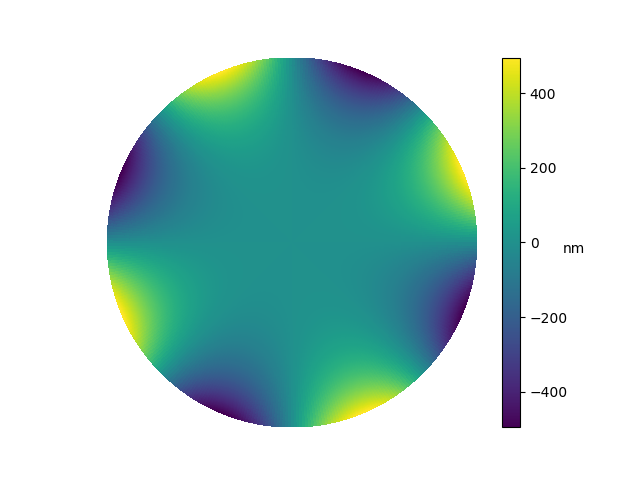

In [292]:
zv.plot_map()
plt.show()